In [3]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import time
import amt.method as md
import amt.data_loader as dl
import pickle 

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
output_folder = '/home/martin/adapative_MC_test/results/simulation'
output_figure_folder = '/home/martin/adapative_MC_test/figures/figure_simu'
output_file = output_folder + '/simulation_nMC.pickle'
# n_hypothesis_list = [1000, 2000, 5000, 10000, 20000, 50000]
n_hypothesis_list = [1000, 2000, 5000, 10000, 20000]
# n_hypothesis_list = [1000, 2000]
n_rep = 5
alpha = 0.1
# n_fMC = int(n_hypothesis / alpha * 2)
# n_fMC_list = [5000, 10000, int(2e4), int(5e4), int(1e5), 
#               int(2e5), int(5e5), int(1e6)]
n_param = len(n_hypothesis_list)
method_list = ['fmc', 'smc50', 'smc100', 'amt']

# Simulation

In [5]:
res_dic = {}
for method in method_list:
    res_dic[method] = {}
    res_dic[method]['n_MC_avg'] = np.zeros([n_param, n_rep], dtype=float)
    res_dic[method]['power'] = np.zeros([n_param, n_rep], dtype=float)
    res_dic[method]['fdp'] = np.zeros([n_param, n_rep], dtype=float)
    res_dic[method]['time'] = np.zeros([n_param, n_rep], dtype=float)
    
for i_param,n_hypothesis in enumerate(n_hypothesis_list):
    n_fMC = 10*n_hypothesis
    for i_rep in range(n_rep):
        print('n_hypothesis=%0.2f, i_rep=%d'%(n_hypothesis,i_rep))
        # Generate ground truth
        p_exact, h = dl.load_demo_data(n_hypothesis=n_hypothesis, pi1=0.2, 
                                       effect_size=2.5, random_state=i_rep)
        tau_exact = md.bh(p_exact, alpha=alpha)
        h_exact = (p_exact <= tau_exact)
        # fMC p-values and MC samples
        start_time = time.time()
        B, p_fmc, t_fmc = md.get_monte_carlo_sample(p_exact, n_permutation=n_fMC)
        tau_fmc = md.bh(p_fmc, alpha=alpha)
        h_fmc = (p_fmc <= tau_fmc)
        res_dic['fmc']['n_MC_avg'][i_param,i_rep] = n_fMC
        res_dic['fmc']['power'][i_param,i_rep] = np.sum(h_fmc&h)/np.sum(h)
        res_dic['fmc']['fdp'][i_param,i_rep] = np.sum(h_fmc&(~h))/np.sum(h_fmc)
        res_dic['fmc']['time'][i_param,i_rep] = time.time()-start_time
        print('# fMC: avg. MC samples = %d, time=%0.2fs'%(np.mean(n_fMC),
                                                          time.time()-start_time))
        print('')
        # AMT 
        start_time = time.time()
        p_hat_ub, p_hat_lb, p_hat, tau_hat, n_amt = md.amt(md.f_sample_dummy, B, n_hypothesis,
                                          alpha=alpha, n_fMC=n_fMC,
                                          verbose=False)
        h_amt = (p_hat_ub <= tau_hat)
        res_dic['amt']['n_MC_avg'][i_param,i_rep] = np.mean(n_amt)
        res_dic['amt']['power'][i_param,i_rep] = np.sum(h_amt&h)/np.sum(h)
        res_dic['amt']['fdp'][i_param,i_rep] = np.sum(h_amt&(~h))/np.sum(h_amt)
        res_dic['amt']['time'][i_param,i_rep] = time.time()-start_time
        print('# AMT: avg. MC samples = %0.1f, time=%0.2fs'%(np.mean(n_amt),
                                                             time.time()-start_time))
        print('# D_hat=%d, D_overlap=%d, D_full=%d'%(md.result_compare(h_amt, h_fmc)))
        print('')
        # smc50
        start_time = time.time()
        p_smc, n_smc = md.sMC(B, r=50)
        tau_smc = md.bh(p_smc, alpha=alpha)
        h_smc = (p_smc <= tau_smc)
        res_dic['smc50']['n_MC_avg'][i_param,i_rep] = np.mean(n_smc)
        res_dic['smc50']['power'][i_param,i_rep] = np.sum(h_smc&h)/np.sum(h)
        res_dic['smc50']['fdp'][i_param,i_rep] = np.sum(h_smc&(~h))/np.sum(h_smc)
        res_dic['smc50']['time'][i_param,i_rep] = time.time()-start_time
        print('# sMC50: avg. MC samples = %0.1f, time=%0.2fs'%(np.mean(n_smc),
                                                             time.time()-start_time))
        print('# D_hat=%d, D_overlap=%d, D_full=%d'%(md.result_compare(h_smc, h_fmc)))
        print('')
        # smc100
        start_time = time.time()
        p_smc, n_smc = md.sMC(B, r=100)
        tau_smc = md.bh(p_smc, alpha=alpha)
        h_smc = (p_smc <= tau_smc)
        res_dic['smc100']['n_MC_avg'][i_param,i_rep] = np.mean(n_smc)
        res_dic['smc100']['power'][i_param,i_rep] = np.sum(h_smc&h)/np.sum(h)
        res_dic['smc100']['fdp'][i_param,i_rep] = np.sum(h_smc&(~h))/np.sum(h_smc)
        res_dic['smc100']['time'][i_param,i_rep] = time.time()-start_time
        print('# sMC100: avg. MC samples = %0.1f, time=%0.2fs'%(np.mean(n_smc),
                                                             time.time()-start_time))
        print('# D_hat=%d, D_overlap=%d, D_full=%d'%(md.result_compare(h_smc, h_fmc)))
        print('')
with open(output_file, "wb") as f:
    pickle.dump(res_dic, f)    

n_hypothesis=1000.00, i_rep=0
# fMC: avg. MC samples = 10000, time=2.04s

# AMT: avg. MC samples = 1200.3, time=0.10s
# D_hat=136, D_overlap=136, D_full=136

# sMC50: avg. MC samples = 1464.6, time=0.13s
# D_hat=137, D_overlap=135, D_full=136

# sMC100: avg. MC samples = 1875.1, time=0.14s
# D_hat=134, D_overlap=134, D_full=136

n_hypothesis=1000.00, i_rep=1
# fMC: avg. MC samples = 10000, time=2.06s

# AMT: avg. MC samples = 1152.5, time=0.08s
# D_hat=151, D_overlap=151, D_full=151

# sMC50: avg. MC samples = 1561.7, time=0.14s
# D_hat=148, D_overlap=148, D_full=151

# sMC100: avg. MC samples = 1961.1, time=0.17s
# D_hat=146, D_overlap=146, D_full=151

n_hypothesis=1000.00, i_rep=2
# fMC: avg. MC samples = 10000, time=2.07s

# AMT: avg. MC samples = 1137.8, time=0.09s
# D_hat=142, D_overlap=142, D_full=142

# sMC50: avg. MC samples = 1474.8, time=0.15s
# D_hat=143, D_overlap=140, D_full=142

# sMC100: avg. MC samples = 1879.6, time=0.14s
# D_hat=143, D_overlap=142, D_full=142

n_hypot

# sMC50: avg. MC samples = 10416.8, time=183.34s
# D_hat=2626, D_overlap=2582, D_full=2626

# sMC100: avg. MC samples = 13355.3, time=176.80s
# D_hat=2634, D_overlap=2604, D_full=2626



# Generate figure

In [3]:
with open(output_file, 'rb')as f:
    res_dic = pickle.load(f)

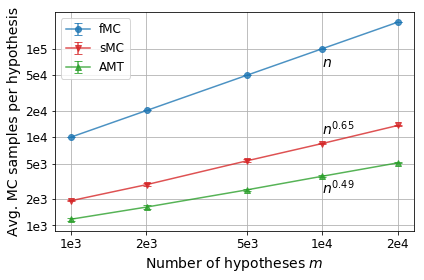

In [65]:
# Generate the figures
output_fig_file = output_figure_folder+'/figure_nMC'
# method_list = ['fmc', 'smc100', 'smc50', 'amt']
# method_dic = {'fmc':'fMC', 'smc50':'sMC (r=50)', 
#               'smc100':'sMC (r=100)', 'amt':'AMT'}
method_list = ['fmc', 'smc100', 'amt']
method_dic = {'fmc':'fMC', 'smc50':'sMC (r=50)', 
              'smc100':'sMC', 'amt':'AMT'}
marker_list = ['o', 'v', '^', '*', 'h', 'd']
color_list = ['C0', 'C3', 'C2', 'C1', 'C5', 'C8']
param_list = n_hypothesis_list
plt.figure()
for i_method,method in enumerate(method_list):
    y_val = np.mean(res_dic[method]['n_MC_avg'], axis=1)
    temp = np.std(res_dic[method]['n_MC_avg'], axis=1) / np.sqrt(n_rep) * 1.96
    y_err = np.zeros([2, n_param], dtype=float) 
    y_err[0,:] = np.log10(y_val) - np.log10(y_val-temp) 
    y_err[1,:] = np.log10(y_val+temp) - np.log10(y_val)
    plt.errorbar(np.log10(param_list), np.log10(y_val), yerr=y_err,
                 label=method_dic[method],
                 capsize=4, elinewidth = 1.5, 
                 linewidth=1.5, color = color_list[i_method], 
                 marker = marker_list[i_method],\
                 markersize = 6, alpha=0.8)
    if method == 'fmc':
        plt.annotate('$n$', (np.log10(param_list)[-2], np.log10(y_val)[-2]-0.2),
                     fontsize=14)
    elif method == 'smc100':
        plt.annotate('$n^{%0.2f}$'%((np.log10(y_val)[-1]-np.log10(y_val)[0])/
                                    (np.log10(param_list)[-1]-np.log10(param_list)[0])),
                     (np.log10(param_list)[-2], np.log10(y_val)[-2]+0.1), fontsize=14)
    elif method == 'smc50':
        plt.annotate('$n^{%0.2f}$'%((np.log10(y_val)[-1]-np.log10(y_val)[0])/
                                    (np.log10(param_list)[-1]-np.log10(param_list)[0])),
                     (np.log10(param_list)[-2], np.log10(y_val)[-2]-0.15), fontsize=14)
    else:
        plt.annotate('$n^{%0.2f}$'%((np.log10(y_val)[-1]-np.log10(y_val)[0])/
                          (np.log10(param_list)[-1]-np.log10(param_list)[0])),
                     (np.log10(param_list)[-2], np.log10(y_val)[-2]-0.2), fontsize=14)
plt.grid()
plt.legend(fontsize=12)
# x_val = np.arange(3, 4.4, 0.2)
# plt.xticks([3, ], ['$3e5$', '$3.2*10^5$', 
#                                  '$10^5$', '$3.2*10^6$', '$10^6$'], fontsize=12)
x_val = [3, 3.3, 3.7, 4, 4.3]
x_tick = []
for x in x_val:
    temp_str = '%0.1e'%(10**x)
    x_tick.append(temp_str.replace('+0', '').replace('.0e','e'))
#     x_tick.append('%0.1e'%(10**x))
plt.xticks(x_val, x_tick, fontsize=12)
y_val = [3, 3.3, 3.7, 4, 4.3, 4.7, 5]
y_tick = []
for y in y_val:
    temp_str = '%0.1e'%(10**y)
    y_tick.append(temp_str.replace('+0', '').replace('.0e','e'))
#     y_tick.append('%0.1e'%(10**y))
plt.yticks(y_val, y_tick, rotation= 0, fontsize=12)
plt.xlabel('Number of hypotheses $m$', fontsize=14)
plt.ylabel('Avg. MC samples per hypothesis', fontsize=14)
plt.tight_layout()
plt.savefig(output_fig_file+'.png')
plt.savefig(output_fig_file+'.pdf')
plt.show()

In [55]:
np.log10(2000)

3.3010299956639813

# Old code

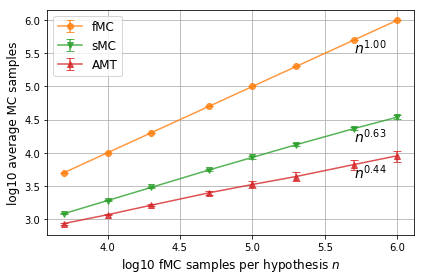

In [28]:
# Generate the figures
output_fig_file = output_figure_folder+'/figure_nMC'
marker_list = ['o', 'v', '^', '*', 'h', 'd']
color_list = ['C1', 'C2', 'C3', 'C0', 'C5', 'C8']
method_dic = {'fmc':'fMC', 'smc':'sMC', 'amt':'AMT'}
plt.figure()
for i_method,method in enumerate(method_list):
    y_val = np.mean(res_dic[method]['n_MC_avg'], axis=1)
    temp = np.std(res_dic[method]['n_MC_avg'], axis=1) / np.sqrt(n_rep) * 1.96
    y_err = np.zeros([2, n_param], dtype=float) 
    y_err[0,:] = np.log10(y_val) - np.log10(y_val-temp) 
    y_err[1,:] = np.log10(y_val+temp) - np.log10(y_val)
    plt.errorbar(np.log10(n_fMC_list), np.log10(y_val), yerr=y_err, label=method_dic[method],\
                 capsize=4, elinewidth = 1.5, linewidth=1.5,\
                 color = color_list[i_method], marker = marker_list[i_method],\
                 markersize = 6, alpha=0.8)
    plt.annotate('$n^{%0.2f}$'%((np.log10(y_val)[-1]-np.log10(y_val)[0])/
                          (np.log10(n_fMC_list)[-1]-np.log10(n_fMC_list)[0])),
                 (np.log10(n_fMC_list)[-2], np.log10(y_val)[-2]-0.2), fontsize=14)
plt.grid()
plt.legend(fontsize=12)
# plt.xticks([4, 4.5, 5, 5.5, 6], ['$10^4$', '$3.2*10^5$', 
#                                  '$10^5$', '$3.2*10^6$', '$10^6$'], fontsize=12)
plt.xlabel('log10 fMC samples per hypothesis $n$', fontsize=12)
plt.ylabel('log10 average MC samples', fontsize=12)
plt.tight_layout()
plt.savefig(output_fig_file+'.png')
plt.savefig(output_fig_file+'.pdf')
plt.show()

In [29]:
res_dic['amt'].keys()

dict_keys(['n_MC_avg', 'power', 'fdp', 'time'])

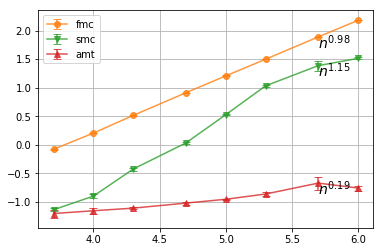

In [8]:
# Generate the figures
marker_list = ['o', 'v', '^', '*', 'h', 'd']
color_list = ['C1', 'C2', 'C3', 'C0', 'C5', 'C8']
plt.figure()
for i_method,method in enumerate(method_list):
    y_val = np.mean(res_dic[method]['time'], axis=1)
    temp = np.std(res_dic[method]['time'], axis=1) / np.sqrt(n_rep) * 1.96
    y_err = np.zeros([2, n_param], dtype=float) 
    y_err[0,:] = np.log10(y_val) - np.log10(y_val-temp) 
    y_err[1,:] = np.log10(y_val+temp) - np.log10(y_val)
    plt.errorbar(np.log10(n_fMC_list), np.log10(y_val), yerr=y_err, label=method,\
                 capsize=4, elinewidth = 1.5, linewidth=1.5,\
                 color = color_list[i_method], marker = marker_list[i_method],\
                 markersize = 6, alpha=0.8)
    plt.annotate('$n^{%0.2f}$'%((np.log10(y_val)[-1]-np.log10(y_val)[0])/
                          (np.log10(n_fMC_list)[-1]-np.log10(n_fMC_list)[0])),
                 (np.log10(n_fMC_list)[-2], np.log10(y_val)[-2]-0.2), fontsize=14)
plt.grid()
plt.legend()
plt.show()

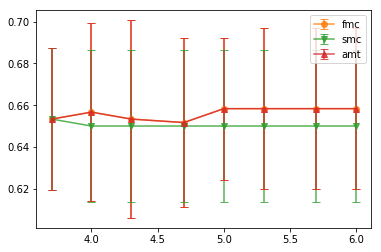

In [5]:
# Generate the figures
marker_list = ['o', 'v', '^', '*', 'h', 'd']
color_list = ['C1', 'C2', 'C3', 'C0', 'C5', 'C8']
plt.figure()
for i_method,method in enumerate(method_list):
    y_val = np.mean(res_dic[method]['power'], axis=1)
    y_err = np.std(res_dic[method]['power'], axis=1) / np.sqrt(n_rep) * 1.96
    plt.errorbar(np.log10(n_fMC_list), y_val, yerr=y_err, label=method,\
                 capsize=4, elinewidth = 1.5, linewidth=1.5,\
                 color = color_list[i_method], marker = marker_list[i_method],\
                 markersize = 6, alpha=0.8)
plt.legend()
plt.show()

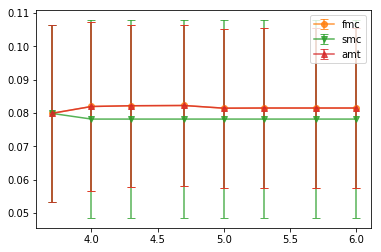

In [7]:
# Generate the figures
marker_list = ['o', 'v', '^', '*', 'h', 'd']
color_list = ['C1', 'C2', 'C3', 'C0', 'C5', 'C8']
plt.figure()
for i_method,method in enumerate(method_list):
    y_val = np.mean(res_dic[method]['fdp'], axis=1)
    y_err = np.std(res_dic[method]['fdp'], axis=1) / np.sqrt(n_rep) * 1.96
    plt.errorbar(np.log10(n_fMC_list), y_val, yerr=y_err, label=method,\
                 capsize=4, elinewidth = 1.5, linewidth=1.5,\
                 color = color_list[i_method], marker = marker_list[i_method],\
                 markersize = 6, alpha=0.8)
plt.legend()
plt.show()